# MNIST dataset
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)) and 
Mikkel Vilstrup ([mvilstrup](https://github.com/MVilstrup)).
</span>

In this notebook we will guide you through building a neural network classifier for the (in)famous MNIST dataset.
MNIST is a dataset that is often used for benchmarking, consisting of 70.000 image-label paris of handwritten digits from 0-9.
During the notebook we have provided a program skeleton and severalt tips to help guid you through it.
Further more the task is quite similar to what you did in the previous notebook, so you should reffer to it in order to remind yourself about the implementation.

Along the way you will also learn about 
* selecting nonlinearity, and
* stochastic gradient descent with mini-batches.

We will implement a dense feedforward neural network (just like before).
In this setting we represent each image as a vector, instead of a 2D map.
We therefore lose the spatial information of the images.
The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance.
This task is therefore called the _permutation invariant_ MNIST.
Obviously this throws away a lot of structure in the data that could have been used.
Later we will see how spatial information can be included, by using the convolutional neural network architecture.


## Implementation Rules

In this exercise we want you to get some experience with setting up training for yourself, and we therefore want you to implement the training loop yourself.
You are therefore **NOT** allowed to use the `keras.models.Sequential.fit` function.
The `Sequential` model, or built in layers, such as `keras.layers.Dense` are allowed, as long as you define the training ops and training loop yourself.
(If are having problems using `keras.layers` have a look at the [Keras as a simplified interface to TensorFlow](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html) tutorial).


In [1]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## The MNIST dataset
The 70,000 images-label pairs are split into a 
* 55,000 images training set, 
* 5,000 images validation set and 
* 10,000 images test set.

The images are 28x28 pixels, where each pixel represents the light intensity normalised value between 0-1 (0=black, 1=white).
The number of features is therefore 28x28=784.

First let's load the MNIST dataset and plot a few examples. TensorFlow has a [convenient MNIST interface](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) that we will use to download and manage the data.

In [2]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


Information on dataset
----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 784
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 10
Label type		 <class 'numpy.float64'>


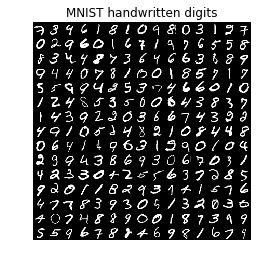

In [3]:
## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training size:\t", mnist_data.train.num_examples)
print("Test size\t", mnist_data.test.num_examples)
print("Validation size\t", mnist_data.validation.num_examples)

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

print('\nData summaries')
print("Image shape\t\t", num_features)
print("Image type\t\t", type(mnist_data.train.images[0][0]))
print("Image min/max value\t", np.min(mnist_data.train.images), '/', np.max(mnist_data.train.images))
print("Label shape\t\t", num_classes)
print("Label type\t\t", type(mnist_data.train.labels[0][0]))


## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.train.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Creating the graph

#### <span style="color:red"> EXE 1) Defining the network
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Define two layers. Remember to give them proper names.
    * Choose any standard nonlinearity. You are encouraged to come back, and compare their performances once you have defined the training loop.
* The non-linearity of the output layer should be softmax ([tf.nn.softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax))


In [4]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
# Depending on your implementation you might need to cast y_pl differently
y_pl = tf.cast(y_pl, tf.float32)

## Define the model
num_neurons = 100
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
b_initializer = tf.constant_initializer(0.0)
with tf.variable_scope('layer1'): 
    W_1 = tf.get_variable('W', [num_features, num_neurons],
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_neurons],
                          initializer=b_initializer)
    with tf.variable_scope('output'):
        
        l_1 = tf.nn.relu(tf.matmul(x_pl, W_1) + b_1)

with tf.variable_scope('layer2'): 
    W_2 = tf.get_variable('W', [num_neurons, num_classes],
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_classes],
                          initializer=b_initializer)
    with tf.variable_scope('output'):
        
        l_2 = tf.matmul(l_1, W_2) + b_2

y_out = tf.nn.softmax(l_2)

#### <span style="color:red"> EXE 2) Defining the training operations.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Cross_entropy loss
* An optimizer and training op
* An op computing the accuracy

In [5]:
### Implement training ops

# 1) Define cross entropy loss
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y_out), axis=[1])

    # Average over samples
    # Averaging makes the loss invariant to batch size, which is very nice.
    cross_entropy = tf.reduce_mean(cross_entropy)
    
# 2) Define the training op
with tf.variable_scope('trainOP'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(cross_entropy)

# 3) Define accuracy op
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    prediction = tf.argmax(y_out, axis=1)
    correct = tf.argmax(y_pl, axis=1)
    correct_prediction = tf.equal(prediction, correct)

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Stochastic gradient descent with mini-batches

In the last notebook we used the entire dataset to compute every parameter update.
For large datasets this is very costly and inefficient.
Instead we can compute the gradient on only a small subset of the data, a *mini-batches*, and use it to update the parameters.
Bath size varies a lot depending on application but between 8-256 is common.
Bigger is not allways better.
With smaller mini-batch size you get more updates and your model might converge faster.
Also small batchsizes uses less memory -> freeing up memory so you train a model with more parameters.

#### <span style="color:red"> EXE 3) Testing the forward pass
</span>

Before building the training loop lets ensure that the forward pass works.

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* define the `feed_dict`
* compute the network predictions (`y_pred`) by passing `x_batch` through the network using `sess.run`

In [6]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x_batch, y_batch = mnist_data.train.next_batch(batch_size)

# Restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    
    ### YOUR CODE HERE ###
    feed_dict = {x_pl: x}
    y_pred = sess.run(y_out, feed_dict)

        
assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Success!')

# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches.
Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples.
The paramters are updated after each mini batch.
Networks converges much faster using minibatches because the paramters are updated more often.



#### <span style="color:red"> EXE 4) Building the training loop.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Perform the training operation
* Collect training statistics
* [Optional] Monitor training in TensorBoard.

In [7]:
max_epochs = 100
x_tr = mnist_data.train.images
y_tr = mnist_data.train.labels
x_val = mnist_data.validation.images
y_val = mnist_data.validation.labels
x_test = mnist_data.test.images
y_test = mnist_data.test.labels

mini_batch_per_epoch = int(mnist_data.train.num_examples/max_epochs)

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

train_cost, val_cost, train_acc, val_acc, train_pred, val_pred = [],[],[],[],[],[]
mnist_data.train._epochs_completed, mnist_data.train._index_in_epoch = 0, 0
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())
        
        while mnist_data.train.epochs_completed < max_epochs:
            # Load one mini-batch
            x_bat, y_bat = mnist_data.train.next_batch(batch_size)
            
            # 1) Run the train op
            train_batch_res = sess.run([train_op], {x_pl: x_bat, y_pl: y_bat})
            
            # 2) Compute train_cost, val_cost, train_acc, val_acc
            if mnist_data.train._index_in_epoch <= batch_size:
                
                train_res = sess.run([cross_entropy, accuracy], {x_pl: x_tr, y_pl: y_tr})
                train_cost += [train_res[0]]
                train_acc += [train_res[1]]

                val_res = sess.run([cross_entropy, accuracy], {x_pl: x_val, y_pl: y_val})
                val_cost += [val_res[0]]
                val_acc += [val_res[1]]
                
                
                # 3) Print training summaries
                if mnist_data.train.epochs_completed % 10 == 0:
                    print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                          %(mnist_data.train.epochs_completed, train_cost[-1],val_cost[-1],val_acc[-1]))

        # save predictions for later use
        train_pred = sess.run(prediction, {x_pl: x_tr})
        val_pred = sess.run(prediction, {x_pl: x_val})
        test_pred = sess.run(prediction, {x_pl: x_test})
                                                                 
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')

Epoch 0, Train Cost: 2.436	Val Cost: 2.447	 Val acc: 0.045
Epoch 10, Train Cost: 0.180	Val Cost: 0.177	 Val acc: 0.950
Epoch 20, Train Cost: 0.120	Val Cost: 0.132	 Val acc: 0.962
Epoch 30, Train Cost: 0.088	Val Cost: 0.109	 Val acc: 0.969
Epoch 40, Train Cost: 0.069	Val Cost: 0.096	 Val acc: 0.970
Epoch 50, Train Cost: 0.056	Val Cost: 0.088	 Val acc: 0.973
Epoch 60, Train Cost: 0.046	Val Cost: 0.083	 Val acc: 0.975
Epoch 70, Train Cost: 0.039	Val Cost: 0.079	 Val acc: 0.977
Epoch 80, Train Cost: 0.033	Val Cost: 0.077	 Val acc: 0.976
Epoch 90, Train Cost: 0.028	Val Cost: 0.076	 Val acc: 0.977
Epoch 100, Train Cost: 0.024	Val Cost: 0.075	 Val acc: 0.977
Done


#### <span style="color:red"> EXE 5) Building the training loop.
</span>

You should have saved training statistics in `train_cost`, `val_cost`, `train_acc`, `val_acc`.
1. Plot train and validation loss as a function of time
2. Plot train and validation accuracy as a function of time
3. Select some random validation images, visualize them, and examine the output of the network.
    * How well does it do? When does it make mistakes?


(<matplotlib.text.Text at 0x2105e3e2518>,
 <matplotlib.text.Text at 0x2105e3ebba8>)

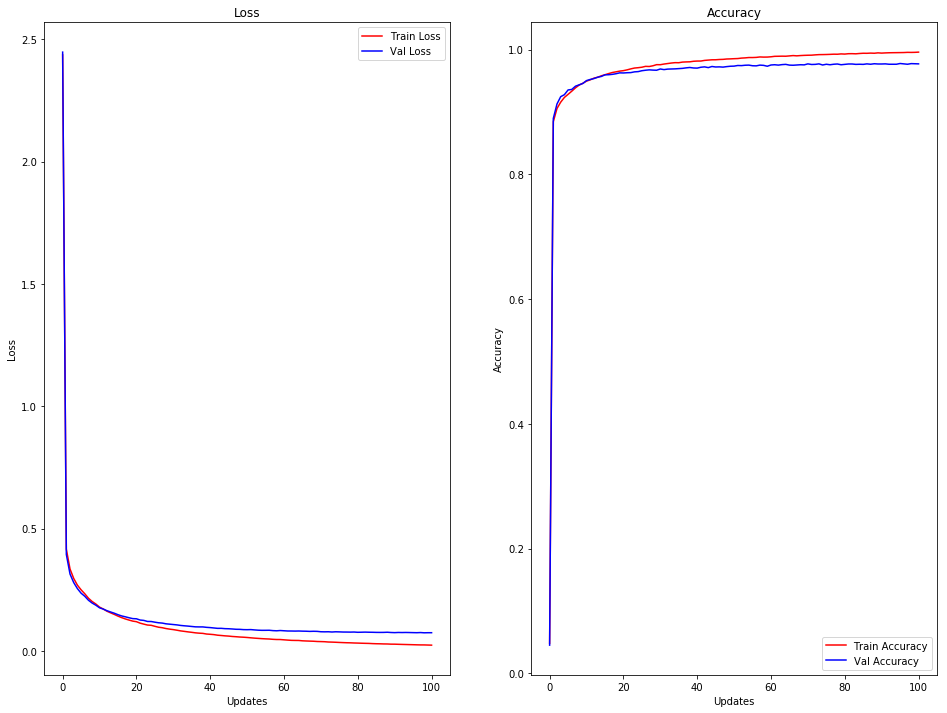

In [8]:
### YOUR CODE HERE ###
# 1) Plot train and validation loss as a function of time
fig = plt.figure(figsize=(16,12))
epoch = np.arange(len(train_cost))

fig.add_subplot(121)
plt.title('Loss')
plt.plot(epoch, train_cost,'r', label='Train Loss')
plt.plot(epoch, val_cost,'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates'), plt.ylabel('Loss')

# 2) Plot train and validation accuracy as a function of time
fig.add_subplot(122)
plt.title('Accuracy')
plt.plot(epoch, train_acc,'r', label='Train Accuracy')
plt.plot(epoch, val_acc,'b', label='Val Accuracy')
plt.legend(loc=4)
plt.xlabel('Updates'), plt.ylabel('Accuracy')

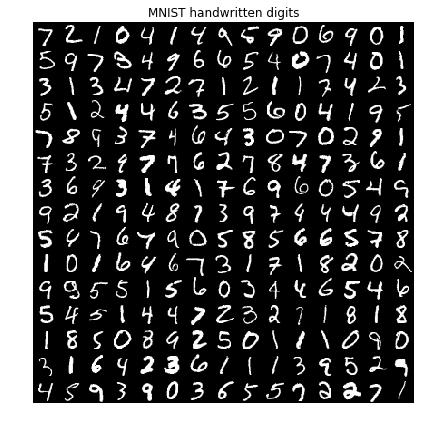

In [9]:
## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        x = mnist_data.train.images[idx]
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.test.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [10]:
# 3) 
print('Predictions:\n{}\n\nCorrect:\n{}'.format(
    test_pred[:img_to_show ** 2].reshape(img_to_show, img_to_show),
    np.apply_along_axis(np.argmax, 1, mnist_data.test.labels[:img_to_show ** 2]).reshape(img_to_show, img_to_show)
))

Predictions:
[[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1]
 [5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
 [3 1 3 4 7 2 7 1 2 1 1 7 4 2 3]
 [5 1 2 4 4 6 3 5 5 6 0 4 1 9 5]
 [7 8 9 3 7 4 6 4 3 0 7 0 2 9 1]
 [7 3 2 9 7 7 6 2 7 8 4 7 3 6 1]
 [3 6 9 3 1 4 1 7 6 9 6 0 5 4 9]
 [9 2 1 9 4 8 7 3 9 7 9 4 4 9 2]
 [5 4 7 6 7 9 0 5 8 5 6 6 5 7 8]
 [1 0 1 6 4 6 7 3 1 7 1 8 2 0 4]
 [9 9 5 5 1 5 6 0 3 4 4 6 5 4 6]
 [5 4 5 1 4 4 7 2 3 2 7 1 8 1 8]
 [1 8 5 0 8 9 2 5 0 1 1 1 0 9 0]
 [3 1 6 4 2 3 6 1 1 1 3 9 5 2 9]
 [4 5 9 3 9 0 3 6 5 5 7 2 2 7 1]]

Correct:
[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1]
 [5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
 [3 1 3 4 7 2 7 1 2 1 1 7 4 2 3]
 [5 1 2 4 4 6 3 5 5 6 0 4 1 9 5]
 [7 8 9 3 7 4 6 4 3 0 7 0 2 9 1]
 [7 3 2 9 7 7 6 2 7 8 4 7 3 6 1]
 [3 6 9 3 1 4 1 7 6 9 6 0 5 4 9]
 [9 2 1 9 4 8 7 3 9 7 4 4 4 9 2]
 [5 4 7 6 7 9 0 5 8 5 6 6 5 7 8]
 [1 0 1 6 4 6 7 3 1 7 1 8 2 0 2]
 [9 9 5 5 1 5 6 0 3 4 4 6 5 4 6]
 [5 4 5 1 4 4 7 2 3 2 7 1 8 1 8]
 [1 8 5 0 8 9 2 5 0 1 1 1 0 9 0]
 [3 1 6 4 2 3 6 1 1 1 3 9 5 2 9]
 [4 5 9 3 9 0 3 6 5

# Closing Remarks

You have now seen several different ways in which feed forward neural networks can be created.
There is no "right" way to define a neural network.
Ideally you should be able to understand how to implement everything at a low-level, and use high-level APIs to reduce human error and speedup development.
There are numerous frameworks which takes care the fundamental concepts are implemented correctly.
In this class we will mostly use Tensorflow and show Keras implementations here and there.
There are however alternatives that each have their strenghts and weaknesses: 
- [Pytorch](http://pytorch.org/)
- [Theano](http://deeplearning.net/software/theano/)
- [CNTK](https://github.com/Microsoft/CNTK)
- [Chainer](https://github.com/chainer/chainer)
- ... etc.

There is no framework that is "better" than the others.
However, each has their particular focus.
Keras tries to be the easiest to use and takes the most "High-level" approach to Deep Learning.
This might be useful at times, however, at others you might want to have more flexibility than such a High-level framework can provide. 

As you will see, FFNs are just one of many types of architectures and from here we will take a look at the extremely useful alternative called Convolutional Neural Networks. 

# Exercise: Sigmoid neurons simutaling perceptrons, part I

A perceptrons output is given by

$$ 
\begin{aligned}
1_{\sum_j w_j x_j + b > 0}  &= 1_{c\left(\sum_j w_j x_j + b\right) > 0} \\
& = 1_{\sum_j c \cdot w_j x_j + c \cdot b > 0}
\end{aligned}
$$

for some constant $c$. Hence multiplying every weight and biases in a network of perceptons does not change the networks behavior.